In [3]:
from hicrep import hicrepSCC
from hicrep import *
from hicrep.utils import readMcool
import numpy as np
from sklearn.manifold import MDS
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# set figure and save dpi
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
chroms_lengths = pd.read_csv("/cta/users/vkaya/hi-c/work/hela/notebooks/hicrep/chrom.sizes.hg38", sep="\t", header=None)
chroms_lengths = np.array(chroms_lengths[1])

In [5]:
def gridS(gridL, plot=False, save=False):    
    end_result = []
    nChr = 23
    samples = [0, 12, 30, 60]
    
    for grid in gridL:
        resolution = grid[0]
        h = grid[1]
        dBPMax = grid[2]
        bDownSample = grid[3]
        
        calc_pairs = []
        calc_pairs_scores = np.ones((len(samples), nChr*len(samples)))
        
        print(grid)
        
        corrV_perChr=[]
        s1=[]
        s2=[]
        chrList=[]
        for i1, sample1 in enumerate(samples):
            for i2, sample2 in enumerate(samples):

                comp = set([sample1, sample2])
                
                if comp not in calc_pairs and sample1 != sample2:
                        print(comp, flush=True)

                        fmcool1 = f"/cta/users/vkaya/gnn/matrix/matrix/t{sample1}_q30.mcool"
                        fmcool2= f"/cta/users/vkaya/gnn/matrix/matrix/t{sample2}_q30.mcool"
                        cool1, binSize1 = readMcool(fmcool1, resolution)
                        cool2, binSize2 = readMcool(fmcool2, resolution)

                        scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample).reshape((1,nChr))
                        calc_pairs_scores[i1, i2*nChr:i2*nChr+nChr] = scc
                        calc_pairs_scores[i2, i1*nChr:i1*nChr+nChr] = scc
                
                        calc_pairs.append(comp)
                    
                        corrV_perChr += scc.flatten().tolist()
                        s1 += [f"su-{sample1}" for i in range(nChr)]
                        s2 += [f"su-{sample2}" for i in range(nChr)]
                        chrList += [f"chr{i}" for i in range(1, nChr)] + ["X"]
                        
        perChr_df = pd.DataFrame({"sample1":s1, "sample2":s2, "corrV":corrV_perChr, "chrId": chrList})

        
        end_result.append(calc_pairs_scores)

        mds = MDS(random_state=0)
        _transformed = mds.fit_transform(calc_pairs_scores)
        df = pd.DataFrame(_transformed, columns = ["c1", "c2"])
        df["samples"] = [str(i) for i in samples]
        df["resolution"] = [resolution for i in samples]
        df["h"] = [h for i in samples]
        df["dBPMax"] = [dBPMax for i in samples]
        df["bDownSample"] = [bDownSample for i in samples]
        filename = f"res{resolution}_h{h}_dBPMax{dBPMax}_bd{bDownSample}"

        if plot:
            fig = px.scatter(df, y="c2", x="c1", color="samples")
            fig.update_traces(marker_size=10)    
            fig.show()

        if save and plot:
            fig.write_html(f"/home/vogulcan/hic-work/hicrep/figs/{filename}.html")

        if save:    
            df.to_csv(f"/home/vogulcan/hic-work/hicrep/figs/{filename}.csv", index=False)
        
    return end_result, df, perChr_df


def scc_all_weighted(scc_arr_List, chr_lens):
    scc = scc_arr_List[0]
    calc_pairs = []
    
    samples = [0, 12, 30, 60]
    nChr = 23
    
    corr_heatmap = np.ones((4,4))
    
    s1 = []
    s2 = []
    corr = []
    
    for i1, sample1 in enumerate(samples):
        for i2, sample2 in enumerate(samples):
                comp = set([sample1, sample2])
                if comp not in calc_pairs:# and sample1 != sample2:
                    
                    
                    scc_current = scc[i1, i2*nChr:i2*nChr+nChr]
                    scc_current_weigthed = np.average(scc_current, weights=chr_lens)
                    corr_heatmap[i1, i2] = scc_current_weigthed
                    corr_heatmap[i2, i1] = scc_current_weigthed
                    
                    s1.append(f"{sample1}")
                    s2.append(f"{sample2}")
                    corr.append(scc_current_weigthed)
                    
                    s1.append(f"{sample2}")
                    s2.append(f"{sample1}")
                    corr.append(scc_current_weigthed)
                    
                    calc_pairs.append(comp)
    
    return corr_heatmap, pd.DataFrame({"sample1":s1, "sample2":s2, "corrV":corr})

In [6]:
scc_all, mds_df, scc_perChr = gridS([
    (50_000, 5, 10_000_000, False)], plot=False, save=False
)

(50000, 5, 10000000, False)
{0, 12}
{0, 30}
{0, 60}
{12, 30}
{12, 60}
{60, 30}


/cta/users/vkaya/miniconda3/envs/gnn/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


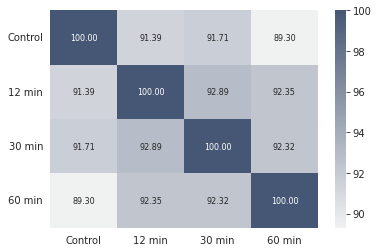

In [121]:
data = scc_all_weighted(scc_all, chroms_lengths)[0]
data = data * 100

cmp = sns.light_palette("#465775", as_cmap=True)

l = sns.heatmap(data, annot=True, cmap=cmp, annot_kws={"size": 8}, fmt=".2f")
# set x tick labels
l.set_xticklabels(["Control", "12 min", "30 min", "60 min"])
l.set_yticklabels(["Control", "12 min", "30 min", "60 min"], rotation=0, va="center")
# save fig
plt.savefig("scc_heatmap.svg", bbox_inches="tight")

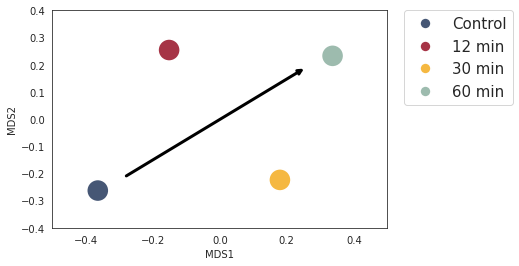

In [124]:
mds_df['Samples'] = ['Control', '12 min', '30 min', '60 min']
mds_df['MDS1'] = mds_df['c1']
mds_df['MDS2'] = mds_df['c2']
l = sns.scatterplot(data=mds_df, x="MDS1", y="MDS2", hue="Samples", s=500, palette=["#465775", "#A63446", "#F5B841", "#9DBBAE"])

l.set_xlim(-0.5, 0.5)
l.set_ylim(-0.4, 0.4)


control_x = mds_df[mds_df["Samples"] == "Control"]["MDS1"].values[0]
control_y = mds_df[mds_df["Samples"] == "Control"]["MDS2"].values[0]

min60_x = mds_df[mds_df["Samples"] == "60 min"]["MDS1"].values[0]
min60_y = mds_df[mds_df["Samples"] == "60 min"]["MDS2"].values[0]

l.annotate("", xy=(control_x + 0.08, control_y + 0.05), xytext=(min60_x - 0.08, min60_y - 0.043), arrowprops=dict(arrowstyle="<-", color="black", lw=3))

l.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize=15, markerscale=0.5)

# save fig
plt.savefig("scc_mds.svg", bbox_inches="tight")